In [213]:
import h5py
import matplotlib
import matplotlib.pyplot as plt
import os
import glob
import mdtraj as md
import numpy as np
from tqdm import tqdm
from westpa_helpers import *

In [221]:
dir_root = "/media/DATA_18_TB_1/andy/benchmark_cache/"
all_native_file_strided_file = dir_root + "proteing_native_trajs_CG_stride100_nrNativePaths2560_300K.pkl"
tica_model_file = dir_root + "proteing_300K.tica"

In [222]:
from report_generator.tica_plots import calc_atom_distance

tica_model = load_tica_model(tica_model_file)

with open(all_native_file_strided_file, 'rb') as all_native_file_strided:
    native_trajs_strided = pickle.load(all_native_file_strided)
    
    native_proj_datas: list[np.typing.NDArray]  = tica_model.decompose([calc_atom_distance(x.trajectory) for x in tqdm(native_trajs_strided)])
    assert not np.isnan(native_proj_datas).any()
    
    strideNative = 1
    native_proj_datas_concat = np.concatenate(native_proj_datas)[::strideNative]


 22%|██▏       | 568/2560 [02:10<12:15,  2.71it/s]

KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.neighbors import KernelDensity

def generate_energy_based_bins(data, num_bins=15, bandwidth=0.2, oversample=5, alpha=0.5):
    """
    Generate rectilinear bins with finer resolution in low-density (high-energy) regions.

    Parameters:
    - data (np.ndarray): 1D TICA projection.
    - num_bins (int): Desired number of bin edges (excluding -inf/inf).
    - bandwidth (float): KDE bandwidth for density estimation.
    - oversample (int): Multiplier for intermediate binning resolution.

    Returns:
    - bin_edges (list): Bin edges including '-inf' and 'inf'.
    """
    # 1. KDE estimate
    data = data.reshape(-1, 1)
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(data)
    grid = np.linspace(data.min(), data.max(), num_bins * oversample).reshape(-1, 1)
    log_density = kde.score_samples(grid)
    density = np.exp(log_density)

    # 2. Blended weights: combine density and inverse-density
    inv_density = 1 / (density + 1e-12)
    blend_weights = alpha * inv_density + (1 - alpha) * density
    norm_weights = blend_weights / blend_weights.sum()

    # 3. Compute cumulative weights and find equally spaced cutoffs
    cdf = np.cumsum(norm_weights)
    cdf /= cdf[-1]
    edges_idx = np.searchsorted(cdf, np.linspace(0, 1, num_bins + 1))

    # 4. Map those indices back to bin edges
    bin_edges = grid[edges_idx].flatten()
    bin_edges = [-np.inf] + list(np.round(bin_edges[1:-1], 2)) + [np.inf]
    
    return bin_edges


In [ ]:
import numpy as np
from sklearn.neighbors import KernelDensity

def generate_energy_based_bins(data, num_bins=15, bandwidth=0.2, oversample=5, alpha=0.5, trim_cdf=0.0):
    """
    Generate rectilinear bins with finer resolution in low-density (high-energy) regions,
    avoiding clustering near data edges by trimming the data range before binning.

    Parameters:
    - data (np.ndarray): 1D TICA projection.
    - num_bins (int): Desired number of bin edges (excluding -inf/inf).
    - bandwidth (float): KDE bandwidth for density estimation.
    - oversample (int): Multiplier for intermediate binning resolution.
    - alpha (float): Blending factor between density and inverse-density.
    - trim_cdf (float): Fraction to trim from each tail of the data distribution before KDE/binning.

    Returns:
    - bin_edges (list): Bin edges including '-inf' and 'inf'.
    """
    data = data.flatten()

    # 1. Trim data range using quantiles (before KDE)
    lower, upper = np.quantile(data, [trim_cdf, 1 - trim_cdf])
    trimmed_data = data[(data >= lower) & (data <= upper)]

    # 2. KDE on trimmed data
    trimmed_data = trimmed_data.reshape(-1, 1)
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(trimmed_data)
    grid = np.linspace(trimmed_data.min(), trimmed_data.max(), num_bins * oversample).reshape(-1, 1)
    log_density = kde.score_samples(grid)
    density = np.exp(log_density)

    # 3. Blended energy-based weights
    inv_density = 1 / (density + 1e-12)
    blend_weights = alpha * inv_density + (1 - alpha) * density
    norm_weights = blend_weights / blend_weights.sum()

    # 4. Cumulative weights for energy-based spacing
    cdf = np.cumsum(norm_weights)
    cdf /= cdf[-1]
    target_cuts = np.linspace(0, 1, num_bins + 1)
    edges_idx = np.searchsorted(cdf, target_cuts)

    # 5. Final bin edges
    bin_edges = grid[edges_idx].flatten()
    bin_edges = [-np.inf] + list(np.round(bin_edges[1:-1], 2)) + [np.inf]

    return bin_edges


In [ ]:
num_bins = 20
bins = []
bins.append(generate_energy_based_bins(native_proj_datas_concat[:, 0], num_bins=num_bins, trim_cdf=0.005))
bins.append(generate_energy_based_bins(native_proj_datas_concat[:, 1], num_bins=num_bins, trim_cdf=.05))

print("TIC 0 Bins:", bins[0])
print("TIC 1 Bins:", bins[1])


In [210]:
# Custom linear-spaced bins to adjust distribution
import numpy as np

new_bins = np.linspace(-2, 0, 10)

# Copy to preserve original
swapped_bins = bins[0].copy()

# Replace even indices (0, 2, 4, ...) up to the length of new_bins
for i, val in enumerate(new_bins):
    index = i * 2
    if index < len(swapped_bins):
        swapped_bins[index] = round(val, 4)  # Rounded for neatness

print("Swapped Bins:", swapped_bins)
bins[0] = swapped_bins

Swapped Bins: [-2.0, -3.36, -1.7778, -3.18, -1.5556, -2.96, -1.3333, -2.78, -1.1111, -2.6, -0.8889, -2.47, -0.6667, -2.16, -0.4444, -1.36, -0.2222, -0.88, 0.0, -0.26, inf]


In [211]:
print([sorted(bins[0]), sorted(bins[1])])

[[-3.36, -3.18, -2.96, -2.78, -2.6, -2.47, -2.16, -2.0, -1.7778, -1.5556, -1.36, -1.3333, -1.1111, -0.8889, -0.88, -0.6667, -0.4444, -0.26, -0.2222, 0.0, inf], [-inf, -2.26, -2.16, -2.05, -1.92, -1.74, -1.57, -1.4, -1.26, -1.12, -1.06, -0.95, -0.88, -0.81, -0.75, -0.64, -0.5, -0.3, 0.12, 0.7, inf]]


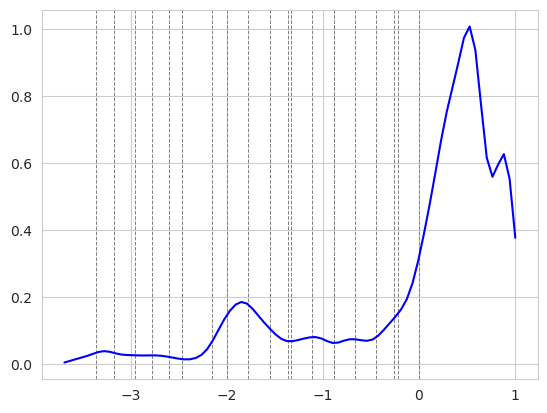

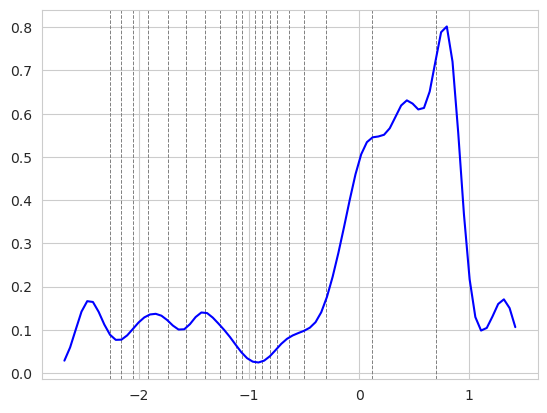

In [212]:
from scipy.stats import gaussian_kde
kde_bins = 80

for i in range(2):
    
    component_min = min(native_proj_datas_concat[:, i])
    component_max = max(native_proj_datas_concat[:, i])
    component_bins = np.linspace(component_min, component_max, kde_bins + 1)
    bin_centers = 0.5 * (component_bins[:-1] + component_bins[1:])
    
    bins_tic_i = [x for x in bins[i] if np.isfinite(x)]
    for b in bins_tic_i:
        plt.axvline(x=b, linestyle='--', color='gray', linewidth=0.7)

    native_kde = gaussian_kde(native_proj_datas_concat[:, i].T)
    native_kde_values = native_kde(bin_centers)
    plt.plot(bin_centers, native_kde_values, label='Native KDE', color='blue')
    plt.show()

